**Set environment**

In [1]:
suppressMessages(suppressWarnings(source("../config/config_sing.R")))
show_env()

You are in Singularity: singularity_proj_encode_fcc 
BASE DIRECTORY (FD_BASE): /data/reddylab/Kuei 
WORK DIRECTORY (FD_WORK): /data/reddylab/Kuei/out 
CODE DIRECTORY (FD_CODE): /data/reddylab/Kuei/code 
PATH OF PROJECT (FD_PRJ): /data/reddylab/Kuei/code/Proj_CombEffect_ENCODE_FCC 
PATH OF RESULTS (FD_RES): /data/reddylab/Kuei/out/proj_combeffect_encode_fcc 
PATH OF LOG     (FD_LOG): /data/reddylab/Kuei/out/proj_combeffect_encode_fcc/log 


## Import data

In [2]:
ASSAY   = "LentiMPRA_K562_Nadav"
FOLDER  = "coverage_astarrseq_peak_macs_input"

fdiry = file.path(FD_RES, "results", ASSAY, FOLDER)
fname = "nadav_K562_MPRA_log2FC_Z_bp.bed.gz"
fpath = file.path(fdiry, fname)

cnames = c(
    "Chrom_Peak", "Start_Peak", "End_Peak",
    "Chrom_Site", "Start_Site", "End_Site", "Site_ID", "Score", 
    "Overlap"
)
dat = read_tsv(fpath, col_names = cnames)

dat_peak_score_import = dat
print(dim(dat))
head(dat)

Rows: 7847988 Columns: 9
── Column specification ─────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): Chrom_Peak, Chrom_Site, Site_ID
dbl (6): Start_Peak, End_Peak, Start_Site, End_Site, Score, Overlap

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 7847988       9


Chrom_Peak,Start_Peak,End_Peak,Chrom_Site,Start_Site,End_Site,Site_ID,Score,Overlap
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
chr1,777949,779437,chr1,778637,778638,id-1,2.17604,1
chr1,777949,779437,chr1,778638,778639,id-2,2.17604,1
chr1,777949,779437,chr1,778639,778640,id-3,2.17604,1
chr1,777949,779437,chr1,778640,778641,id-4,2.17604,1
chr1,777949,779437,chr1,778641,778642,id-5,2.17604,1
chr1,777949,779437,chr1,778642,778643,id-6,2.17604,1


**Check results**

In [3]:
### overlap should be all one
table(dat_peak_score_import$Overlap)


      1 
7847988 

## Arrange

In [4]:
dat = dat_peak_score_import
dat = dat %>% 
    dplyr::mutate(
        Peak = paste0(Chrom_Peak, ":", Start_Peak, "-", End_Peak),
        Site = paste0(Chrom_Site, ":", Start_Site, "-", End_Site)) %>%
    dplyr::select(
        Peak, Site, Score
    )

###
dat_peak_score_arrange = dat
print(dim(dat))
head(dat)

[1] 7847988       3


Peak,Site,Score
<chr>,<chr>,<dbl>
chr1:777949-779437,chr1:778637-778638,2.17604
chr1:777949-779437,chr1:778638-778639,2.17604
chr1:777949-779437,chr1:778639-778640,2.17604
chr1:777949-779437,chr1:778640-778641,2.17604
chr1:777949-779437,chr1:778641-778642,2.17604
chr1:777949-779437,chr1:778642-778643,2.17604


## Summary

In [9]:
###
dat = dat_peak_score_arrange
dat = dat %>% dplyr::mutate(Sign  = ifelse(Score > 0, "pos", "neg"))
table(dat$Sign)


    pos 
7847988 

In [5]:
###
dat = dat_peak_score_arrange
dat = dat %>% dplyr::mutate(Sign  = ifelse(Score > 0, "pos", "neg"))

###
dat_sum_total = dat %>%
    dplyr::group_by(Peak) %>%
    dplyr::summarise(
        Mean    = mean(Score),
        Median  = median(Score),
        Max     = max(Score),
        Min     = min(Score),
        Count   = n(),
        .groups = "drop"
    )

###
dat_sum_sign = dat %>%
    dplyr::group_by(Peak, Sign) %>%
    dplyr::summarise(Mean = mean(Score), .groups = "drop") %>% 
    dplyr::mutate(Sign = dplyr::recode(Sign, `pos` = "Mean_Pos", `neg` = "Mean_Neg")) %>% 
    tidyr::spread(Sign, Mean)

###
dat = dplyr::left_join(
    dat_sum_total,
    dat_sum_sign,
    by = c("Peak")) %>% 
    replace(is.na(.), 0)

dat_peak_score_summary = dat
print(dim(dat))
head(dat)

[1] 37180     7


Peak,Mean,Median,Max,Min,Count,Mean_Pos
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
chr10:100045961-100046653,0.065811,0.065811,0.065811,0.065811,200,0.065811
chr10:100228452-100230090,2.158430,2.158430,2.158430,2.158430,200,2.158430
chr10:100267066-100268374,1.338820,1.338820,1.338820,1.338820,200,1.338820
chr10:100285974-100287341,1.322260,1.322260,1.322260,1.322260,200,1.322260
chr10:100289686-100290090,0.548885,0.548885,0.548885,0.548885,200,0.548885
chr10:100342247-100342824,0.176936,0.176936,0.176936,0.176936,200,0.176936


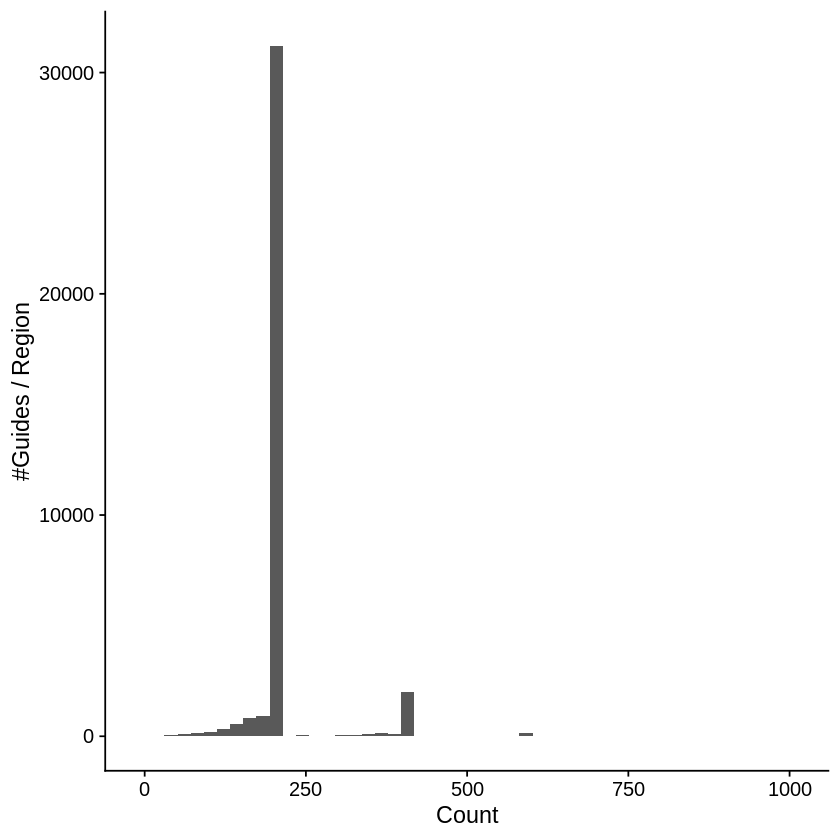

In [6]:
dat = dat_peak_score_summary
gpt = ggplot(dat, aes(x=Count)) + 
    geom_histogram(bins = 50) + 
    labs(y="#Guides / Region") +
    theme_cowplot()
print(gpt)

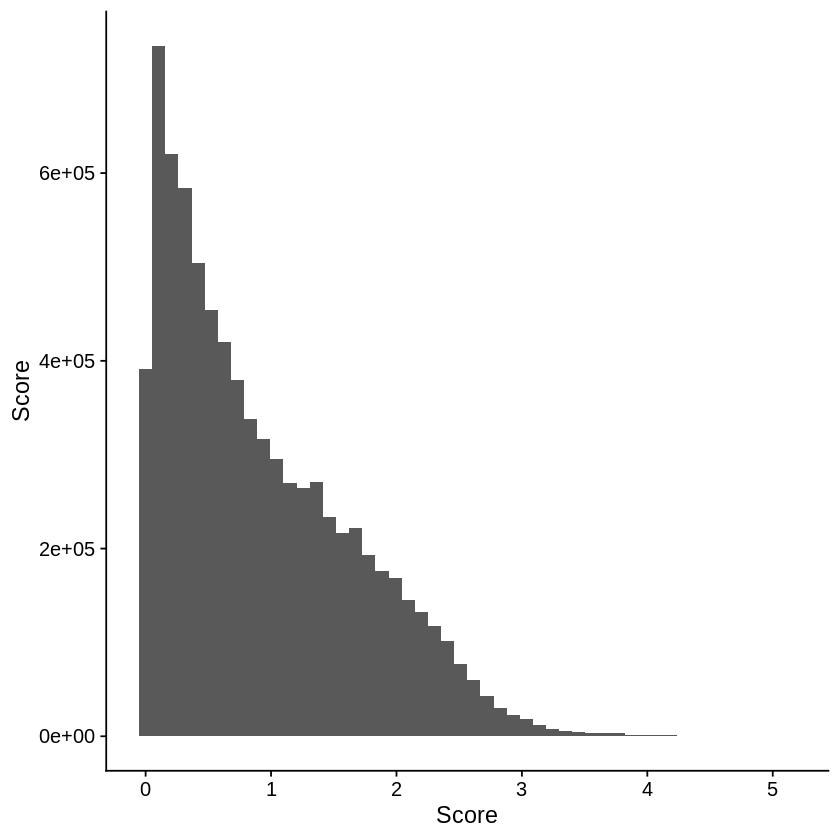

In [10]:
dat = dat_peak_score_arrange
gpt = ggplot(dat, aes(x=Score)) + 
    geom_histogram(bins = 50) + 
    labs(y="Score") +
    theme_cowplot()
print(gpt)

## Save results

In [7]:
fdiry = file.path(FD_RES, "results", ASSAY, FOLDER, "summary")
fname = "results.score.tsv"
fpath = file.path(fdiry, fname)

dat = dat_peak_score_arrange
write_tsv(dat, fpath)

In [8]:
fdiry = file.path(FD_RES, "results", ASSAY, FOLDER, "summary")
fname = "results.summary.tsv"
fpath = file.path(fdiry, fname)

dat = dat_peak_score_summary
write_tsv(dat, fpath)